**Intent Detection - Enron**


In [39]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

In [40]:
df_train=pd.read_csv("enron_train.txt",sep="\t",header=None)
df_test=pd.read_csv("enron_test.txt",sep="\t",header=None)

In [41]:
df_train.columns=["pred","content"]
df_test.columns=["pred","content"]

In [42]:
df_train['pred'].value_counts()

No     1938
Yes    1719
Name: pred, dtype: int64

In [43]:
df_test['pred'].value_counts()

No     683
Yes    309
Name: pred, dtype: int64

In [44]:
#REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,#]')
#BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
#STOPWORDS = set(stopwords.words('english'))

#def clean_text(text):
#    text = text.lower()
#    text = text.lstrip()
#    text = text.rstrip()
#    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
#    text = BAD_SYMBOLS_RE.sub(' ', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = re.sub(r'\d+', '', text)
#    text = re.sub(r"\s+"," ",text)
#    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
#    return text

In [45]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,?#]')
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = text.lstrip()   
    text = text.rstrip()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = re.sub(r"https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+","$WEBLINKS",text)
    text = re.sub(r"\$\d+", "$CASH",text)
    text = re.sub(r'[\w\.-]+@[\w\.-]+', "$EMAIL",text)
    text = re.sub(r'\b(me|her|him|us|them|there|that)\b', "$NOUN",text)  
    return text

In [46]:
df_train['content'] = df_train['content'].astype(str).apply(clean_text)
df_test['content'] = df_test['content'].astype(str).apply(clean_text)

In [47]:
df_train.to_excel('train_analyze.xlsx')
df_test.to_excel('test_analyze.xlsx')

In [48]:
STOPWORDS = set(stopwords.words('english'))

In [49]:
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    return [lemmatizer.lemmatize(word) for word in word_tokenize(text) if len(word)>2 and (word not in STOPWORDS)]

# Create TF-IDF Vectors

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(min_df=0.01,tokenizer=tokenizer,stop_words=STOPWORDS)

X_train_tfidf = tfidf_vec.fit_transform(df_train['content'])

C:\Users\risha\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'ll", "'re", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [70]:
print(dict(zip(tfidf_vec.get_feature_names(), tfidf_vec.idf_)))

{"'ll": 4.45973970058756, "'re": 5.19733864371834, "'ve": 5.491099762246503, '...': 5.127134385045092, 'able': 5.42048219503255, 'access': 5.541110182821164, 'account': 5.292648823522665, 'add': 5.144228818404391, 'address': 4.661377046680807, 'also': 4.693812322433961, 'app': 5.567085669224425, 'attached': 5.515792374836875, 'available': 4.65079493735027, 'back': 4.773855030107498, 'best': 5.541110182821164, 'book': 5.398009339180491, 'business': 5.292648823522665, 'call': 3.7240329056088197, 'cash': 5.3128515308401845, 'chance': 5.491099762246503, 'change': 5.127134385045092, 'check': 4.970565324353552, 'click': 5.11032726672871, 'come': 5.0937979647775, 'company': 5.4670022106674425, 'conference': 5.354524227240752, 'contact': 4.941991951909495, 'copy': 5.292648823522665, 'could': 4.27019789582012, 'customer': 5.567085669224425, 'day': 4.531842994488905, 'deal': 5.045788745591139, 'dinner': 5.354524227240752, 'discus': 3.8386958139289598, 'discussion': 5.253428110369383, 'e-mail': 4

In [51]:
X_test_tfidf  = tfidf_vec.transform(df_test['content'])

In [71]:
print(dict(zip(tfidf_vec.get_feature_names(), tfidf_vec.idf_)))

{"'ll": 4.45973970058756, "'re": 5.19733864371834, "'ve": 5.491099762246503, '...': 5.127134385045092, 'able': 5.42048219503255, 'access': 5.541110182821164, 'account': 5.292648823522665, 'add': 5.144228818404391, 'address': 4.661377046680807, 'also': 4.693812322433961, 'app': 5.567085669224425, 'attached': 5.515792374836875, 'available': 4.65079493735027, 'back': 4.773855030107498, 'best': 5.541110182821164, 'book': 5.398009339180491, 'business': 5.292648823522665, 'call': 3.7240329056088197, 'cash': 5.3128515308401845, 'chance': 5.491099762246503, 'change': 5.127134385045092, 'check': 4.970565324353552, 'click': 5.11032726672871, 'come': 5.0937979647775, 'company': 5.4670022106674425, 'conference': 5.354524227240752, 'contact': 4.941991951909495, 'copy': 5.292648823522665, 'could': 4.27019789582012, 'customer': 5.567085669224425, 'day': 4.531842994488905, 'deal': 5.045788745591139, 'dinner': 5.354524227240752, 'discus': 3.8386958139289598, 'discussion': 5.253428110369383, 'e-mail': 4

In [52]:
print("Train Shape : ",X_train_tfidf.shape)
print("Test Shape  : ",X_test_tfidf.shape)

Train Shape :  (3657, 130)
Test Shape  :  (992, 130)


In [53]:
train_pred=df_train["pred"]
test_pred=df_test["pred"]

# Splitting Original Training Set into 80% Train & 20% Validation

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
X_train,X_val,Y_train,Y_val=train_test_split(X_train_tfidf,train_pred,test_size=.20,random_state=40)

# Changing predictor values into numerics

In [56]:
Y_train=Y_train.map({"No":0,"Yes":1})
Y_val=Y_val.map({"No":0,"Yes":1})

# Checking Validation Accuracy with various classifiers

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
# try library : LightGBM and XGBoost


In [58]:
svc = SVC(kernel='rbf', gamma="scale")
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
lrc = LogisticRegression(solver='liblinear', penalty='l2',C=10.)
rfc = RandomForestClassifier(n_estimators=100, random_state=111,n_jobs=-1,max_depth=7) 

In [59]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'LR': lrc, 'RF': rfc}

In [60]:
def train(clf, features, targets):    
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [61]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, Y_train)
    pred = predict(v, X_val)
    pred_scores_word_vectors.append((k, [accuracy_score(Y_val,pred)]))

In [62]:
predictions = pd.DataFrame.from_items(pred_scores_word_vectors,orient='index', columns=['Score'])
predictions

C:\Users\risha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


,Score
SVC,0.711749
KN,0.594262
NB,0.700820
LR,0.733607
RF,0.700820


In [63]:
import matplotlib.pyplot as plt
import numpy as np

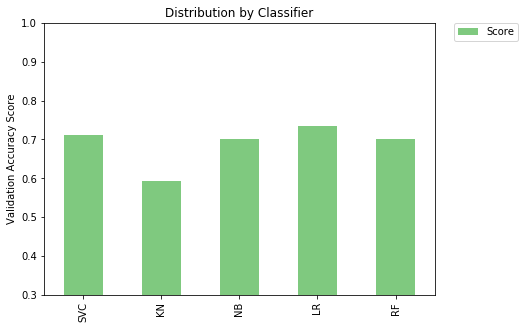

In [64]:
predictions.plot(kind='bar', ylim=(0.3,1.0), figsize=(7,5), align='center', colormap="Accent")
plt.xticks(np.arange(5), predictions.index)
plt.ylabel('Validation Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Let's test our model on the test set provided with our various classifiers

In [65]:
test_pred=test_pred.map({"No":0,"Yes":1})

In [66]:
tester = pd.DataFrame()

In [67]:
tester['LR_Model']=lrc.predict(X_test_tfidf)
tester['SVC_Model']=svc.predict(X_test_tfidf)
tester['RF_Model']=rfc.predict(X_test_tfidf)
tester['KNC_Model']=knc.predict(X_test_tfidf)
tester['NB_Model']=mnb.predict(X_test_tfidf)

# Logistic Regression Model

In [68]:
print('Testing accuracy: %s' % accuracy_score(tester['LR_Model'],test_pred))
print('Testing F1 score: {}'.format(f1_score(tester['LR_Model'],test_pred), average='weighted'))
print('Classification Report:')
print(classification_report(tester['LR_Model'],test_pred))

Testing accuracy: 0.7661290322580645
Testing F1 score: 0.649546827794562
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       639
           1       0.70      0.61      0.65       353

   micro avg       0.77      0.77      0.77       992
   macro avg       0.75      0.73      0.74       992
weighted avg       0.76      0.77      0.76       992



# SVC Model

In [31]:
print('Testing accuracy: %s' % accuracy_score(tester['SVC_Model'],test_pred))
print('Testing F1 score: {}'.format(f1_score(tester['SVC_Model'],test_pred), average='weighted'))
print('Classification Report:')
print(classification_report(tester['SVC_Model'],test_pred))

Testing accuracy: 0.7842741935483871
Testing F1 score: 0.6284722222222222
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       725
           1       0.59      0.68      0.63       267

   micro avg       0.78      0.78      0.78       992
   macro avg       0.73      0.75      0.74       992
weighted avg       0.80      0.78      0.79       992



# Random Forest Model

In [32]:
print('Testing accuracy: %s' % accuracy_score(tester['RF_Model'],test_pred))
print('Testing F1 score: {}'.format(f1_score(tester['RF_Model'],test_pred), average='weighted'))
print('Classification Report:')
print(classification_report(tester['RF_Model'],test_pred))

Testing accuracy: 0.7973790322580645
Testing F1 score: 0.6298342541436465
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       758
           1       0.55      0.73      0.63       234

   micro avg       0.80      0.80      0.80       992
   macro avg       0.73      0.77      0.75       992
weighted avg       0.82      0.80      0.81       992



# Checking Feature Importances of RF

In [72]:
print(dict(zip(tfidf_vec.get_feature_names(), rfc.feature_importances_)))

{"'ll": 0.002073239439388362, "'re": 0.0007762551772150313, "'ve": 0.0017424582733723917, '...': 0.0006828505200295851, 'able': 0.00038794996741555945, 'access': 0.0008775354709102634, 'account': 0.0008501852103154805, 'add': 0.0033867917841217156, 'address': 0.0019032105072934742, 'also': 0.0015068757869964367, 'app': 0.0018777492410849811, 'attached': 3.817124157499585e-05, 'available': 0.0007554244881770401, 'back': 0.0008996444009069294, 'best': 0.0006048181485114511, 'book': 0.0024113713523134877, 'business': 0.002054392196917253, 'call': 0.0874875952907968, 'cash': 0.0016578362125546893, 'chance': 0.001096029691442392, 'change': 0.0026834711278233155, 'check': 0.0016747670048873084, 'click': 0.003572643938688133, 'come': 0.0029434849455780205, 'company': 0.002810707383009429, 'conference': 0.001379477342599763, 'contact': 0.0024008353102397424, 'copy': 0.004360847916420917, 'could': 0.02780105504094692, 'customer': 0.0008607410848980348, 'day': 0.00967403082864298, 'deal': 0.0002

# K-Neighbours Classifier

In [33]:
print('Testing accuracy: %s' % accuracy_score(tester['KNC_Model'],test_pred))
print('Testing F1 score: {}'.format(f1_score(tester['KNC_Model'],test_pred), average='weighted'))
print('Classification Report:')
print(classification_report(tester['KNC_Model'],test_pred))

Testing accuracy: 0.7379032258064516
Testing F1 score: 0.3719806763285024
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.74      0.83       887
           1       0.25      0.73      0.37       105

   micro avg       0.74      0.74      0.74       992
   macro avg       0.60      0.74      0.60       992
weighted avg       0.88      0.74      0.79       992



# Multinomial Naive Bayes Model

In [34]:
print('Testing accuracy: %s' % accuracy_score(tester['NB_Model'],test_pred))
print('Testing F1 score: {}'.format(f1_score(tester['NB_Model'],test_pred), average='weighted'))
print('Classification Report:')
print(classification_report(tester['NB_Model'],test_pred))

Testing accuracy: 0.7399193548387096
Testing F1 score: 0.6205882352941177
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       621
           1       0.68      0.57      0.62       371

   micro avg       0.74      0.74      0.74       992
   macro avg       0.72      0.71      0.71       992
weighted avg       0.73      0.74      0.73       992



# LGBM Classifier

In [35]:
from lightgbm import LGBMClassifier

In [36]:
lgbm = LGBMClassifier(max_depth=10, n_estimators = 150).fit(X_train,Y_train)

In [37]:
tester['LGBM_Model']=lgbm.predict(X_test_tfidf)

In [38]:
print('Testing accuracy: %s' % accuracy_score(tester['LGBM_Model'],test_pred))
print('Testing F1 score: {}'.format(f1_score(tester['LGBM_Model'],test_pred), average='weighted'))
print('Classification Report:')
print(classification_report(tester['LGBM_Model'],test_pred))

Testing accuracy: 0.7711693548387096
Testing F1 score: 0.6513056835637481
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       650
           1       0.69      0.62      0.65       342

   micro avg       0.77      0.77      0.77       992
   macro avg       0.75      0.74      0.74       992
weighted avg       0.77      0.77      0.77       992

